In [1]:
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
#!pip install torch_geometric
#!pip install pyvista
#%pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html
#%pip install pyvista==0.44.1

In [2]:
import torch
from utils import DelaunayTransform
from torch_geometric.data import Data
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
torch.__version__, pv.__version__

/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN3c109TupleTypeC1ESt6vectorINS_4Type24SingletonOrSharedTypePtrIS2_EESaIS4_EESt8optionalINS_13QualifiedNameEESt10shared_ptrINS_14FunctionSchemaEE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN3c109TupleTypeC1ESt6vectorINS_4Type24SingletonOrSharedTypePtrIS2_EESaIS4_EESt8optionalINS_13QualifiedNameEESt10shared_ptrINS_14FunctionSchemaEE
  warnings.warn(f"An issue occurred while importing 'torch-spar

('2.0.1+cu117', '0.44.1')

In [27]:
N = 1000
pos = torch.rand((N, 2))
data = Data(pos=pos, surf=torch.full((N, 1), False))
transform = DelaunayTransform()
print(data.pos.shape)
data = transform(data)
data.pos = pos

data = torch.load('./sampleData.pth')
def plot_graph(data, l=1, plotter=None, node_colors=None):
    
    c = ['r', 'g', 'b', 'm']
    
    p = pv.Plotter() if plotter is None else plotter
    
    # Création d'un PolyData pour les points (nœuds)
    mesh = pv.PolyData()
    
    # Gestion des dimensions des positions
    if data.pos.shape[1] != 3:
        # Ajouter une troisième dimension si nécessaire
        mesh.points = np.concatenate([data.pos.cpu().numpy(), np.full((data.pos.shape[0], 1), l)], axis=1)
    else:
        mesh.points = data.pos.cpu().numpy()

    # Création des lignes pour les arêtes
    edges = data.edge_index.t().cpu().numpy()
    lines = np.hstack([np.full((edges.shape[0], 1), 2), edges]).ravel()
    mesh.lines = lines
    
    
    # Ajout des couleurs au PolyData
    mesh.point_data['values'] = node_colors if node_colors is not None else np.random.randint(0, 255, size=(data.pos.shape[0], 3))
    
    # Ajouter le mesh avec les couleurs des nœuds
    p.add_mesh(mesh, scalars='values', line_width=0.5, point_size=0.3, render_points_as_spheres=True)

    # Si aucun plotter n'a été fourni, on montre la figure
    if plotter is None:
        p.show()

torch.Size([1000, 2])


In [4]:
#plot_graph(data)
device = torch.device('cuda')
data = data.to(device)

torch.Size([6])
[tensor([     3,      6,      9,  ..., 261651, 261653, 261655]), tensor([262145, 262147, 262149,  ..., 262139, 262141, 262143]), tensor([     1,      4,      7,  ..., 262021, 262023, 262025]), tensor([131072, 131074, 131076,  ..., 131066, 131068, 131070]), tensor([     0, 106497,      2, 106500,      5, 106503,      8, 106506,     11,
        106509,     14,   2062, 106512,     17, 106515,     20, 106518,     23,
        106521,     26,  18458, 106524,     29, 106527,     32, 106530,     35,
        106533,     38, 106536,     41,   6187,     44, 106539, 106542,     47,
         14383, 106545,     50, 106548,     53, 106551,     56, 106554,     59,
        106557,     62, 106560,     65, 106563,     68,  10308, 106566,     71,
        106569,     74, 106572,     77, 106575,     80, 106578,     83,  20565,
            86, 106581, 106584,     89, 106587,     92, 106590,     95, 106593,
            98, 106596,    101, 106599,    104, 106602,    107, 106605,    110,
       

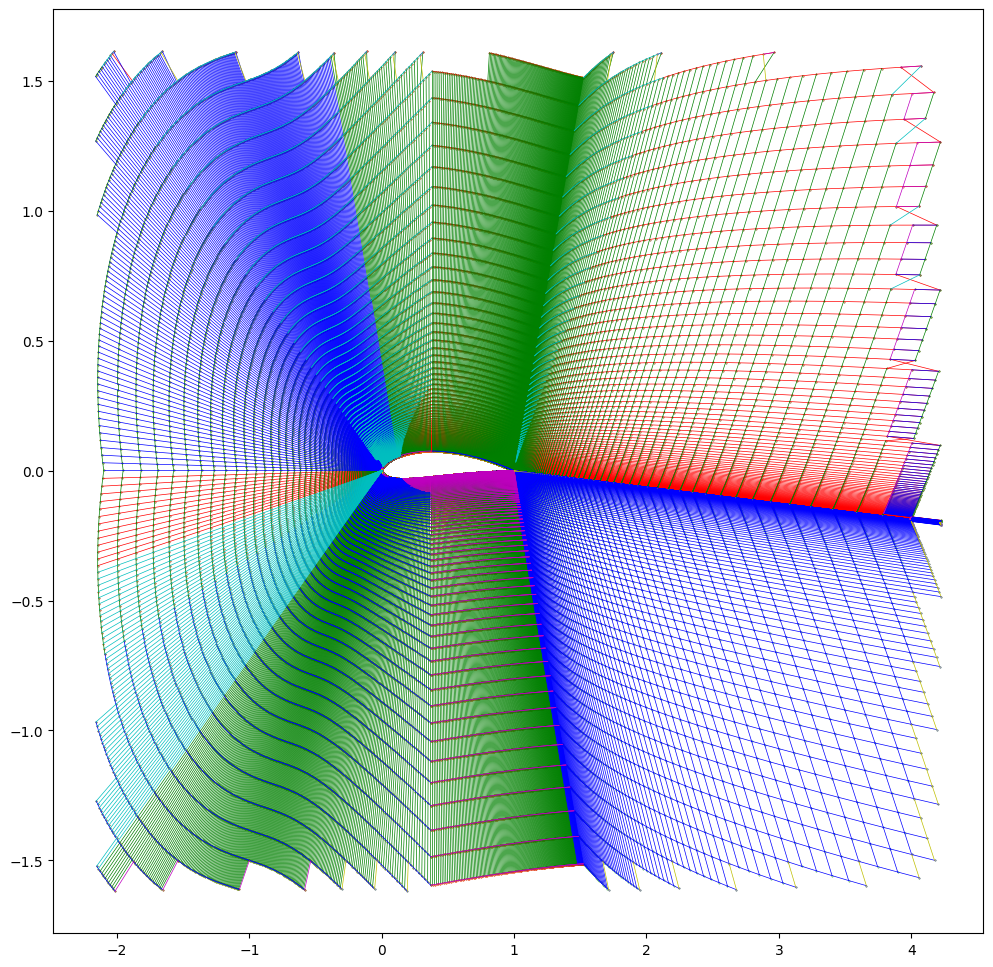

In [81]:
def divide_mesh(v: torch.Tensor, e: torch.Tensor, k: int):
    """Divide a mesh into k clusters of edges according to their direction.

    Args:
        v (Tensor(N, 2)): Positions of the vertices in the mesh.
        e (Tensor(2, N)): Edge indices of the mesh.
        k (int): Number of clusters to divide the mesh into.

    Returns:
        
    """
    clusters = [set() for _ in range(k)]
    
    # Randomly initialize centroids (2D points)
    centroids = torch.rand((k, 2), device=v.device)

    # Precompute edge directions and norms
    edges_directions = v[e[:, 1]] - v[e[:, 0]]
    edges_norms = torch.norm(edges_directions, dim=1, keepdim=True)  # Shape: [num_edges, 1]
    edges_directions /= edges_norms  # Normalize edge directions
    norm_changes = float('inf')
    while norm_changes > 1e-3:
        # Vectorized clustering step
        centroids_norms = torch.norm(centroids, dim=1, keepdim=True)  # Shape: [num_centroids, 1]
        cosine_angles = torch.matmul(edges_directions, centroids.T) / (centroids_norms.T)  # Shape: [num_edges, num_centroids]
        # We use directly the cosine because they have opposite variations
        min_edge_idxs = torch.argmax(cosine_angles, dim=1)  # Shape: [num_edges]
        # Efficient assignment to clusters using torch
        cluster_masks = [(min_edge_idxs == i) for i in range(k)]
        for i in range(k):
            clusters[i] = set((torch.nonzero(cluster_masks[i]).squeeze(1).tolist()))

        # Efficient centroid update
        n_m = 0.0
        for i in range(k):
            if clusters[i]:  # Check if the cluster has assigned edges
                cluster_edges = edges_directions[torch.tensor(list(clusters[i]), device=v.device)]
                last_centroid = centroids[i].clone()
                centroids[i] = torch.mean(cluster_edges, dim=0)
                n_m = max(torch.norm(centroids[i] - last_centroid), n_m)
        norm_changes = n_m

    # Post-process clusters to finalize edge indices
    
    clusters_edge_indices = [torch.tensor(list(cluster), device=v.device) for cluster in clusters]
    nodes = [torch.unique(e[cluster].view(-1)) for cluster in clusters_edge_indices]
    angles = torch.rad2deg(torch.atan(centroids[:, 1] / centroids[:, 0]))
    print(angles)
    return clusters_edge_indices, nodes


data.pos = data.pos[:, :2]
clusters, nodes = divide_mesh(data.pos, data.edge_index.T, 6)
#col = ['r', 'g', 'b', 'm', 'y', 'c']
#plt.figure(figsize=(12, 12))
#for c in range(len(clusters)):
#    plt.scatter(data.pos[nodes[c], 0].cpu().numpy(), data.pos[nodes[c], 1].cpu().numpy(), s=0.1)
#    edges = clusters[c]
#    edges = data.edge_index[:, edges]
#    edge_pos = data.pos[edges]
#
#    for i in range(edge_pos.shape[1]):
#        plt.plot(edge_pos[:, i, 0].cpu().numpy(), edge_pos[:, i, 1].cpu().numpy(), c=col[c], linewidth=0.5)
#


/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


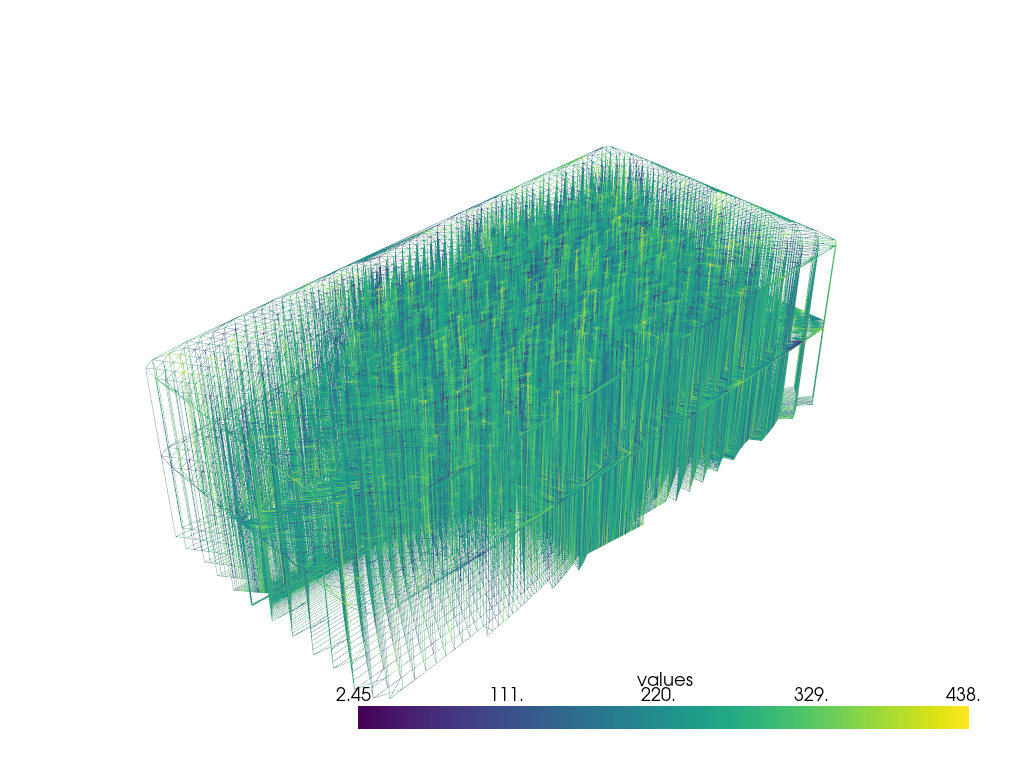

In [6]:
import torch
from torch_cluster import grid_cluster
from torch_scatter import scatter

def generate_coarse_graph(data, r, clusters_per_layer):
    """Generate a coarse graph from a fine graph.

    Args:
        data (Data): The fine graph to coarsen.
        r (int): The coarsening factor.

    Returns:
        (Data, Tensor(N, 2), list(Tensor(C), Tensor(C)): The coarsened graph, the connection edge index, the clusters and the number of edges per coarse element of a subgraph.
    """
    #FIXME: use square grid 
    size = torch.max(data.pos, dim=0)[0] - torch.min(data.pos, dim=0)[0]

    size /= r
    
    # Assign each node to a grid cell id
    cluster = grid_cluster(data.pos, size) 
    
    # Get the indices of the unique clusters
    _, new_index, counts = torch.unique(cluster, return_inverse=True, return_counts=True)
    # Gather each node to its cluster and compute the mean for position features
    out_positions = scatter(data.pos.t(), new_index, reduce='mean')
    
    out_x = scatter(data.x.t(), new_index, reduce='mean')
    
    # Interpolate the other features accordingly to the position    
    surf = scatter(data.surf.to(torch.int), new_index, reduce='max')
    connection_edge_index = torch.stack([new_index+data.num_nodes, torch.arange(0, new_index.shape[0], device=new_index.device)], dim=0)
    
    transform = DelaunayTransform()
    data = transform(Data(pos=out_positions.t()[:, :2].to(data.pos.device), x=out_x.t().to(data.pos.device), surf=surf, device=data.pos.device))
    new_clusters, new_cluster_nodes = divide_mesh(data.pos, data.edge_index.T, clusters_per_layer)
    s = torch.Tensor([c.shape[0] for c in new_clusters])
    
    # Average edges per coarse element in a subgraph
    m = torch.round(((torch.sum(counts)//(2*counts.shape[0]))*6)*(s/torch.sum(s))).int()
    return data, connection_edge_index, new_clusters, m, new_cluster_nodes
    
def generate_coarse_graphs(data, R: int, K: int, visualize=False):
    data = data.cpu() # Quicker to compute on CPU
    range_ = 7500
    edge_clusters, new_cluster_nodes = divide_mesh(data.pos, data.edge_index.T, K)
    data.clusters = edge_clusters
    data.node_clusters = new_cluster_nodes
    base = data.clone()
    base.R = R
    base.clusters_per_layer = K
    base.edge_frequencies = []
    base.layer_ranges = torch.zeros((R, 2), device=base.pos.device, dtype=torch.int)
    base.layer_ranges[0] = torch.tensor([0, base.pos.shape[0]], device=base.pos.device)
    base.up_scale_edge_ranges = torch.zeros((R-1, 2), device=base.pos.device, dtype=torch.int)
    if visualize:
        base.pos = torch.concatenate([base.pos, torch.full((base.pos.shape[0], 1), 1, device=base.pos.device)], axis=1)
    s = [base.pos.shape[0]]
    for i in range(2, R+1):
        subgraph, connection_index, new_clusters, edge_frequencies, new_cluster_nodes = generate_coarse_graph(data, range_//(5**i), base.clusters_per_layer) # TODO: choose the right scale factor
        base.edge_frequencies.append(edge_frequencies)
        base.node_clusters.extend([ c+base.pos.shape[0] for c in new_cluster_nodes])
        data = subgraph.clone()
        s.append(subgraph.pos.shape[0])
        # We got the subgraph with new positions of the new layer and edges
        
        new_clusters = [torch.add(c, base.pos.shape[0]) for c in new_clusters]
        subgraph.clusters = new_clusters
        
        # We need to add the new dimension to the positions to visualize them
        if visualize:
            subgraph.pos = torch.concatenate([subgraph.pos, torch.full((subgraph.pos.shape[0], 1), i, device=subgraph.pos.device)], axis=1) # TODO: remove it

        # We need to add the new edges to the base graph so the new nodes ids have to be shifted by the number of nodes in the base graph
        subgraph.edge_index = torch.add(subgraph.edge_index, base.pos.shape[0])
        
        # We need to connect the new nodes to the base graph nodes
        connection_index = torch.add(connection_index, sum(s[:-2]))

        base.pos = torch.cat([base.pos, subgraph.pos], dim=0) # TODO: use barycentric interpolation
        base.surf = torch.cat([base.surf, subgraph.surf], dim=0) 
        base.x = torch.cat([base.x, subgraph.x], dim=0)
        base.clusters.extend(subgraph.clusters)
        base.edge_index = torch.cat([base.edge_index, subgraph.edge_index, connection_index], dim=1)
        
        base.up_scale_edge_ranges[i-2] = torch.tensor([base.pos.shape[0]-connection_index.shape[1], base.pos.shape[0]], device=base.pos.device) # TODO: check it
        base.layer_ranges[i-1] = torch.tensor([base.pos.shape[0]-subgraph.pos.shape[0], base.pos.shape[0]], device=base.pos.device)
        
        if i >= R:
            last_one_frequencies = torch.full((K,), 1, device=base.pos.device, dtype=torch.int) 
            base.edge_frequencies.append(last_one_frequencies)
            # TODO
    return base

device = torch.device("cuda" if False else "cpu")
b = generate_coarse_graphs(data.cpu(), 3, 5, visualize=True).to(device)
#print("Final graph", b, flush=True)
plot_graph(b)


In [7]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
b = b.to(device)
b.layer_ranges

tensor([[     0, 170180],
        [170180, 187646],
        [187646, 190702]], dtype=torch.int32)

tensor(66354)
torch.Size([1954, 128]) torch.Size([2, 1417]) torch.Size([1417, 128])
tensor(0) tensor(1954)


/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


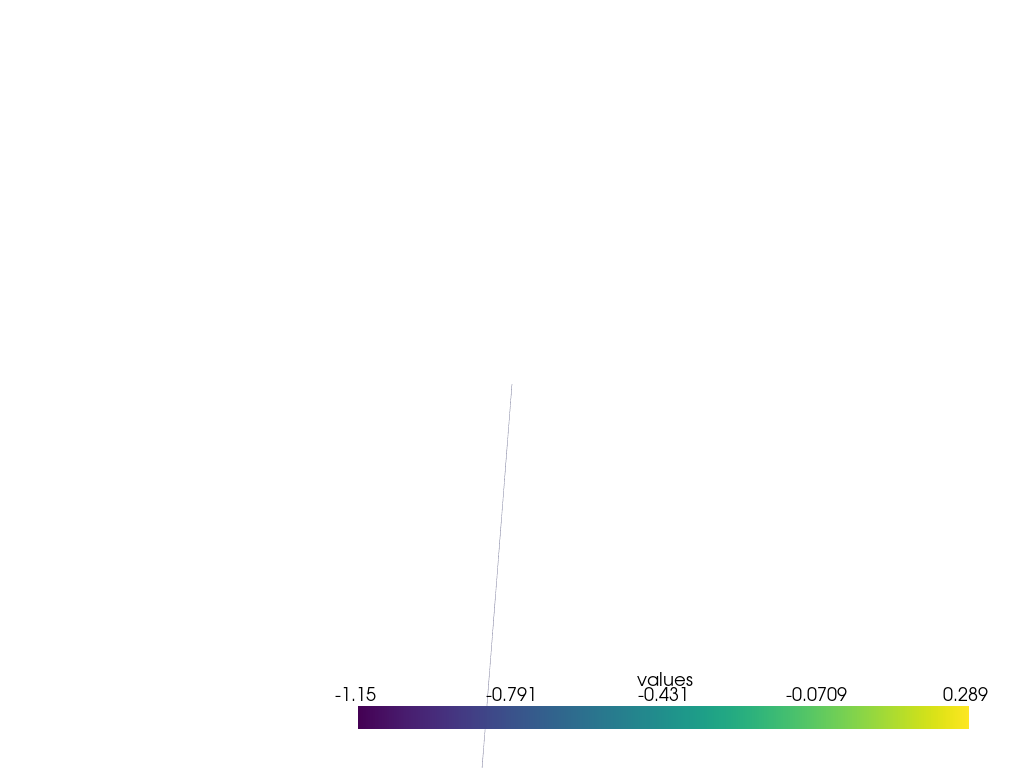

IndexError: Found indices in 'edge_index' that are larger than 1953 (got 1954). Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 1954) in your node feature matrix and try again.

In [8]:
#%%timeit
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
import importlib
import my_model
importlib.reload(my_model)

# Reload the model
model = my_model.UaMgnn(5, 4, R=3, K=5, device=device)
model(b).shape

In [9]:
#color = torch.tensor([0.0], device=device)
#colors = color.repeat(b.pos.shape[0], 1)
#colors[torch.logical_not(b.surf)] = torch.tensor([1.0], device=device)
#print(torch.mean(colors, dim=0), flush=True)
#plot_graph(b, l=1, node_colors=colors.cpu().numpy())

In [187]:
edges = torch.IntTensor([
    [0, 1, 2, 3],
    [1, 2, 3, 4]
])   

nodes_index_of_subgraph = torch.IntTensor([0, 1, 3, 4])
edge_indices_of_subgraph = torch.IntTensor([0, 3])

mask = torch.full((int(torch.max(edges))+1,), 1, dtype=torch.int32)
mask[nodes_index_of_subgraph] = 0

mask = torch.cumsum(mask, dim=0)
edge_of_subgraph = edges[:, edge_indices_of_subgraph]
edge_of_subgraph -= mask[edge_of_subgraph]

edge_of_subgraph

tensor([[0, 2],
        [1, 3]], dtype=torch.int32)

utiliser les mêmes offset que lors de l'initialisation pour obtenir les sous graphes